## Taller 3
### Diego Ulises Cruz
#### 201412142

In [1]:
%pylab inline
import scipy
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.ndimage import gaussian_filter1d
from IPython.display import Markdown as md

Populating the interactive namespace from numpy and matplotlib


In [2]:
masa=152.0 # masa del Kart (kg)
a=0.2231 # Distancia del centro de gravedad al eje de la llanta trasera (m)
l=1.0063 # Distancia de eje de las llantas traseras y delanteras (m)
h=0.07478 # Altura del centro de gravedad del kart con respecto al piso (m)
mu_c=1 #coeficiente de adherencia de las ruedas
# Datos Llantas tractivas 
rll=0.139 # Radio geométrico de las llantas en traseras (m)
refc=0.98*rll # Radio efectivo llantas traseras (m)
rin=0.0631 #radio interno del neumático (m)
etaf=0.95
g=9.81
w=masa*g
ng=7.9

# Datos Fuerzas de la fórmula de aceleración
rho=1.1955 # densidad del aire (kg/m^3)
dll=0.975 # Distancia entre ejes de llantas delanteras (m)
alj=0.88 # Altura con el piloto sentado en el kart (estatura 1.68 m) (m)
af=(dll*alj)/2 # Area Frontal Kart (m^2)
cd=0.89 # Coeficiente de Arrastre Kart
vw=0.0 # velocidad del viento (m/s)
theta=0.0 # Angulo carretera

# Inercias
ii=5.2E-3 # Inercia motor de combustión (kg m^2) 

mllt=1.43 # Masa llantas traseras (kg)
mlld=1.20 # Masa llantas delanteras (kg)
rlld=0.129 # Radio llantas delanteras (m)
rind=0.0631 # Radio rin llantas delanteras (m)
mbt=0.7*mllt # El porcentaje de la masa total que pesa la parte "banda" de la llanta trasera
mdt=0.3*mllt # El porcentaje de la masa total que pesa la parte "disco" de la llanta trasera
mbd=0.7*mlld # El porcentaje de la masa total que pesa la parte "banda" de la llanta delantera
mdd=0.3*mlld # El porcentaje de la masa total que pesa la parte "disco" de la llanta delantera
illd=(mbd*rlld)+(mdd*(rlld**2-rind**2))/2 # Inercia 1 llanta delantera (kg-m^2)
illt=(mbt*rll)+(mdt*(rll**2-rin**2))/2 # Inercia 1 llanta trasera (kg-m^2)
illTot=2*illd+2*illt

# Datos eje llantas
reje=0.02 # Radio eje de las llantas (m)
meje=3.832 # Masa del eje (kg)
ieje=(meje*reje**2)/2.0 # Inercia del eje de las llantas (kg-m^2)

# Fuerzas Aceleración
# Resistencia a la rodadura
a=0.2231 # Distancia del centro de gravedad al eje de la llanta trasera (m)
l=1.0063 # Distancia de eje de las llantas traseras y delanteras (m)
h=0.07478 # Altura del centro de gravedad del kart con respecto al piso (m)

masa_eq=((illTot)+(ieje)+(ii*ng**2))/refc**2

In [3]:
def frodadura(vx,ax):
    wr=w*((a/l)+(ax/g*(h/l))) # fuerza vertical sobre las llantas tractivas
    fr=0.01*(1+(vx/100.0)) # Factor de rodadura la velocidad del kart debe estar en (km/h)
    return wr*fr*np.cos(theta) # (N)

In [4]:
def farrastre(vx):
    return (1/2)*rho*af*cd*(vx+vw)**2  #(N)

In [5]:
def torquemotor(vx,ax):
    T=refc*((masa_eq+masa)*a+frodadura(vx,ax)+farrastre(vx))/(ng-etaf)
    if T<0:
        T=0
    return T

In [6]:
def vangularmotor(vx,ng):
    w=(vx*ng)/refc 
    rev=2*np.pi/60
    if w<(rev*50):
        w=rev*50
    if w>(rev*5000):
        w=rev*5000
        
    return w

In [7]:
def der_num(vector,tiempo):
    acel=[]
    dt = tiempo[1]-tiempo[0]
    for i,v in enumerate (vector):
            if i<len(vector)-1:
                a=(vector[i+1]-vector[i])/dt
                acel.append(a)
    return acel

In [8]:
def mapa_filtrado(tipo,x):
    res=[]
    if tipo=='combustion':
        
        inicio=8578
        fin=14500
        for i,v in enumerate (x):
            if (i>=inicio) & (i<=fin):
                res.append(v)
    if tipo=='electrico':
        inicio=5750
        fin=8900
        for i,v in enumerate (x):
            if (i>=inicio) & (i<=fin):
                res.append(v)
    return np.asarray(res)

In [9]:
def data(tipo):
    ng=0
    base_dir=0
    data_file=0
    sats = []
    time = []
    lat = []
    long = []
    vel = []
    height = []
    vertv = []
    torque=[]
    v_angular=[]
    potencia=[]
    if tipo=='combustion':
        ng=7.909
        base_dir = 'data_combustion'
        data_file = 'VBOX0024.VBO'
    if tipo=='electrico':
        ng=3.5454
        base_dir = os.path.join('.','data_electrico')
        data_file = 'VBS__052.VBO'
    
    with open(os.path.join(base_dir,data_file), 'r') as vboxdata:
            
            for line in vboxdata:
                if line[0] == '[':
                    sats= str.replace(line, "\n","")
                    continue
                if  sats == '[column names]':
                    col_names = str.replace(line, "  \n","").split('  ')
                    sats = []
                if  sats == '[data]':
                    linesplit = str.replace(line, " \n","").split(' ')
                    time.append(float(linesplit[1][0:2])*3600+float(linesplit[1][2:4])*60+float(linesplit[1][4:]))
                    lat.append(float(linesplit[2]))
                    long.append(float(linesplit[3]))
                    vel.append(float(linesplit[4]))
                    height.append(float(linesplit[6]))
                    vertv.append(float(linesplit[7]))
                    
        
    time= np.asarray(time)
    time= mapa_filtrado(tipo,time)
        
    lat= np.asarray(lat)
    lat=mapa_filtrado(tipo,lat)
        
    long= np.asarray(long)
    long= mapa_filtrado(tipo,long)
        
    vel= np.asarray(vel)
    vel= mapa_filtrado(tipo,vel)*1000/3600
 
    vel=gaussian_filter1d(vel,5)
        
        
       
    time_base = time[0]
    time= time - time_base
    lat= lat/60.0
    long= long/60.0
    dt = time[1]-time[0]
   
    ac=der_num(vel,time)
    for i,a in enumerate(ac):
        
        torque.append(torquemotor(vel[i],ac[i]))
        v_angular.append(vangularmotor(vel[i],ng))
        p=torquemotor(ac[i],vel[i])*vangularmotor(vel[i],ng)
        potencia.append(p)
            
    potencia=np.array(potencia)   
    md("Tiempo de Vuelta: %i [s]" %max(time))
    draft(long,lat,vel,ac,torque,v_angular,potencia) 
    print("Tiempo de Vuelta: %.2f [s]" %(max(time)))

In [10]:
def draft(long, lat, vel, acel, torq, vangular,pot):
    ind=['Pista','Velocidad [m/s]','Aceleracion [$m/s^2$]','Torque [Nm]','Velocidad angular [rad/s]','Potencia [kW]']
    i_plus=1
    i_plus_c=0
    long2=[]
    lat2=[]
    
    for i,t in enumerate(long):
        if i<len(long)-1:
            long2.append(long[i])
            lat2.append(lat[i])
    long2=np.array(long2)
    lat2=np.array(lat2)
    
    for i in ind:
        d=0
        if i=='Velocidad [m/s]':
            d=vel
        if i=='Aceleracion [$m/s^2$]':
            d=acel
        if i=='Torque [Nm]':
            d=torq
        if i=='Velocidad angular [rad/s]':
            d=vangular
        if i=='Potencia [kW]':
            d=pot            
        plt.figure()
        if i=='Velocidad [m/s]':
            plt.scatter(long,lat,c=d)
            plt.xlim([min(long)-0.0001,max(long)+0.0001])
            plt.ylim([min(lat)-0.0001,max(lat)+0.0001])
            plt.colorbar()
        if (i!='Pista')&(i!='Velocidad [m/s]'):
            plt.scatter(long2,lat2,c=d)
            plt.xlim([min(long)-0.0001,max(long)+0.0001])
            plt.ylim([min(lat)-0.0001,max(lat)+0.0001])
            plt.colorbar()
        plt.title(i)   
        plt.axis('off')  
        plt.plot(long,lat,'k') 
        
        
        i_plus=i_plus+1
        i_plus_c=i_plus_c+1
    plt.show()

### Kart Combustion Interna

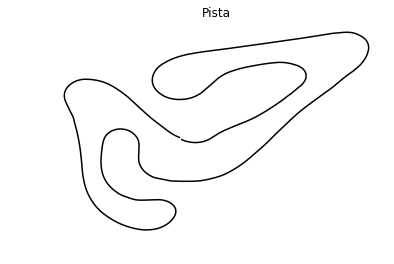

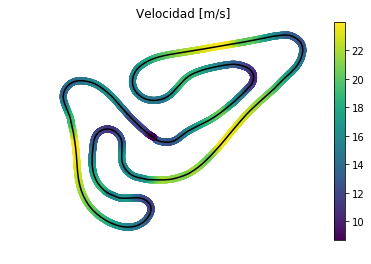

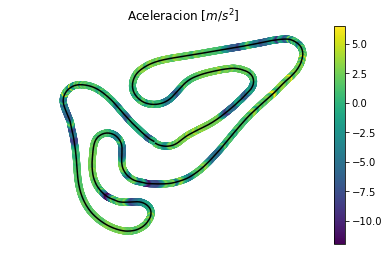

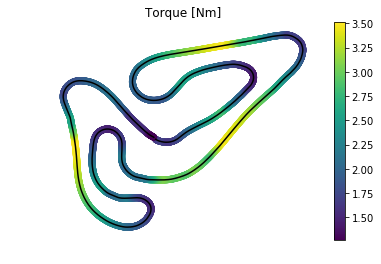

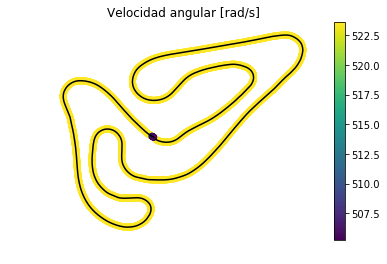

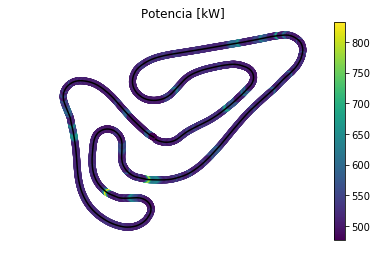

Tiempo de Vuelta: 59.22 [s]


In [11]:
data("combustion")

### Kart Eléctrico

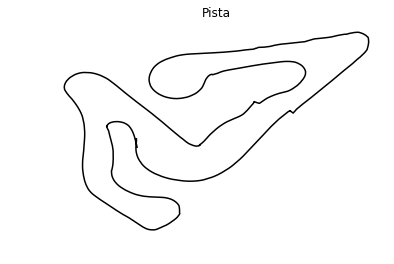

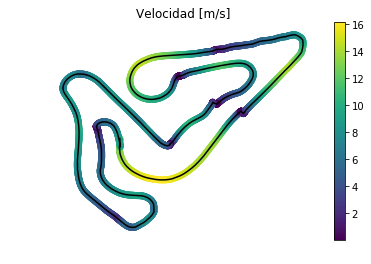

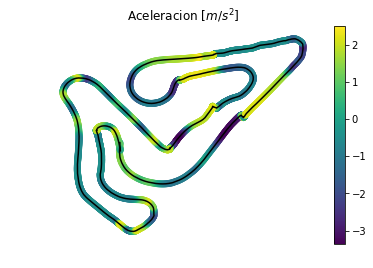

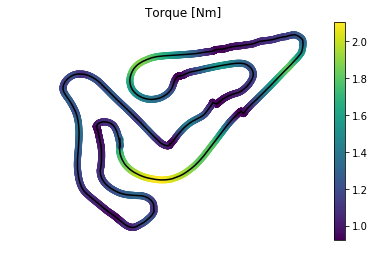

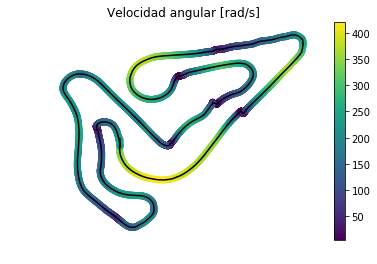

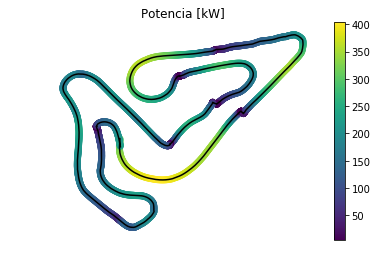

Tiempo de Vuelta: 217.90 [s]


In [12]:
data("electrico")

## Discusión

Como se puede apreciar entre las dos gráficas, el kart a gasolina obtuvo un menor tiempo de vuelta, esto se debe a que este kart poseía más potencia que el eléctrico, a su vez, el eléctrico presentaba aceleraciones bastante menores 2 m/s^2 en comparación al de combustible que llegaban a ser de 5 m/s^2. Tambien se puede apreciar un comportamiento completamente contrario en la potencia entre estos dos vehículos, mientras el kart eléctrico ofrecía en la mayoría de puntos su máxima potencia, el kart de combustible la mayoría de tiempo tuvo su potencia al mínimo.

En el caso del kart eléctrico, yo diría que se puede disminuir el tiempo con una mejor vuelta, ya que se puede apreciar según el contorno de la vuelta, que el movimiento que tuvo este kart fue bastante peor en comparación al de combustible.

## Posibles mejoras

* Una posible mejora podría utilizar una relación de transmision más grande en el kart eléctrico.
* Utilizar baterías más ligeras, aunque estas sean de mayor costo por su novedad.
* Cambiar el motor eléctrico DC por uno que alcance una mayor velocidad angular para seguir utilizando la misma reducción.
* Realizar las pruebas con el mismo piloto para asegurarse que las fallas no sean por pericia entre pilotos.